# Daria Bromot - FS500047

## Automated Spam Filtering using Naive Bayes

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sklearn
import pickle
import csv

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve

In [19]:
# Install NLP packages
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
!pip install textblob
from textblob import TextBlob

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bromotdi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bromotdi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bromotdi\AppData\Roaming\nltk_data...


## Step 1: Load data, look around

In [37]:
messages = pandas.read_csv('SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE, names=["label", "message"])
print(messages)

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5569  spam  This is the 2nd time we have tried 2 contact u...
5570   ham               Will ü b going to esplanade fr home?
5571   ham  Pity, * was in mood for that. So...any other s...
5572   ham  The guy did some bitching but I acted like i'd...
5573   ham                         Rofl. Its true to its name

[5574 rows x 2 columns]


In [72]:
from pivottablejs import pivot_ui
pivot_ui(messages)

With `pandas`, we can also view aggregate statistics easily:

In [38]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4827   
        unique                    4518   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

How long are the messages?

In [39]:
messages['length'] = messages['message'].map(lambda text: len(text))
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


<AxesSubplot:ylabel='Frequency'>

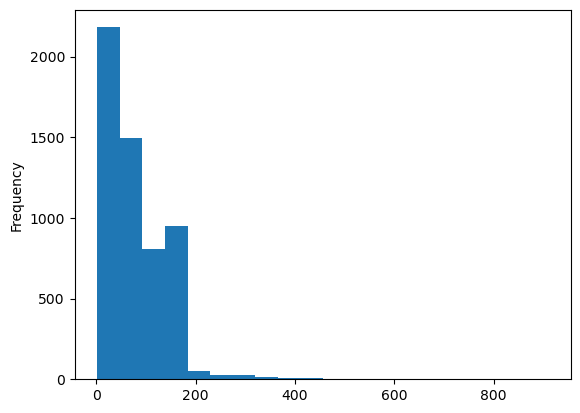

In [40]:
messages.length.plot(bins=20, kind='hist')

In [41]:
messages.length.describe()

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

What is that super long message?

In [42]:
print(list(messages.message[messages.length > 900]))

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


Is there any difference in message length between spam and ham?

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

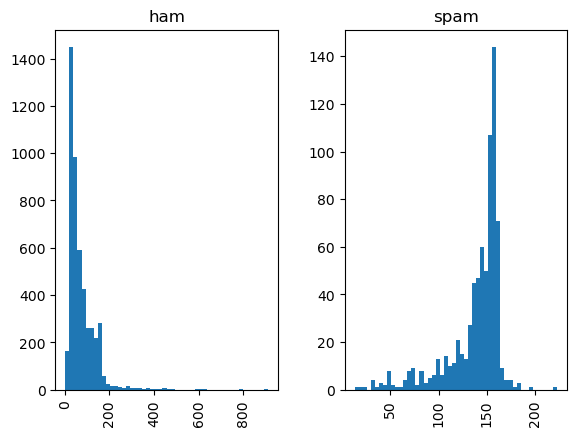

In [102]:
messages.hist(column='length', by='label', bins=50)

Good fun, but how do we make computer understand the plain text messages themselves? Or can it under such malformed gibberish at all?

Computers can process plain text messages using various natural language processing (NLP) techniques, allowing them to understand and derive meaning from the text. However, understanding malformed or nonsensical gibberish can be challenging for computers as it deviates from the typical structure and semantics of coherent language. Let's explore how computers handle plain text messages and the challenges they may face:

1. Language Models: Advanced language models, such as transformer-based models like GPT-3, have been trained on extensive amounts of text data, enabling them to generate coherent and contextually relevant responses to plain text messages. These models utilize statistical patterns and language structures learned from the training data to understand and generate text.

2. Preprocessing: Prior to processing text, computers often perform preprocessing tasks such as tokenization, stemming, and removing stop words. These steps help break down the text into smaller units (tokens) and eliminate irrelevant or commonly occurring words.

3. Syntax and Grammar: NLP techniques leverage syntactic and grammatical rules to analyze and understand the structure of sentences. This includes identifying parts of speech, sentence boundaries, and grammatical relationships between words.

4. Semantic Analysis: Semantic analysis aims to derive meaning from text by examining word context, relationships, and dependencies. Techniques like word embeddings or distributional semantics can represent words in a high-dimensional space based on their semantic similarity, allowing computers to understand the meaning of words and phrases.

5. Named Entity Recognition (NER): NER algorithms can identify and extract named entities from text, such as person names, locations, organizations, or dates. This helps computers recognize and interpret specific entities mentioned in plain text messages.

6. Sentiment Analysis: Sentiment analysis algorithms use machine learning to determine the sentiment or emotional tone expressed in a text message, whether it is positive, negative, or neutral. This helps computers understand the overall sentiment conveyed in plain text.

7. Intent Recognition: Intent recognition models are trained to identify the underlying intent or purpose of a user's text message. By analyzing the keywords and context, these models can categorize user input into specific intents, enabling computers to understand the user's desired action or query.

It's important to note that while computers can handle and understand coherent language to a certain extent, their ability to comprehend malformed gibberish or nonsensical text is limited. Such text may pose challenges in terms of deriving meaningful interpretations or generating appropriate responses.

## Step 2: Data preprocessing

In this section we'll massage the raw messages (sequence of characters) into vectors (sequences of numbers).

The mapping is not 1-to-1; we'll use the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.

As a first step, let's write a function that will split a message into its individual words:

In [44]:
def split_into_tokens(message):
    message = message.encode('utf8').decode()  # convert bytes into proper unicode
    return TextBlob(message).words

Here are some of the original texts again:
    

In [45]:
messages.message.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

...and here are the same messages, tokenized:

In [46]:
messages.message.head().apply(split_into_tokens)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

NLP questions:

1. Do capital letters carry information?
2. Does distinguishing inflected form ("goes" vs. "go") carry information?
3. Do interjections, determiners carry information?

In natural language processing (NLP), the treatment of capital letters, inflected forms, interjections, and determiners can vary depending on the specific task or analysis being performed. Here are some general considerations:

1. Capital letters: Capitalization can carry information in certain contexts. For example, proper nouns or the first letter of a sentence can provide cues about named entities or sentence boundaries. However, in many NLP applications, capitalization is often normalized or ignored to reduce the dimensionality of the data and to focus on the core semantic content of the text.

2. Inflected forms: Distinguishing inflected forms, such as verb conjugations ("goes" vs. "go"), can carry valuable information. The choice of verb form can indicate tense, person, number, or other grammatical features. In some NLP tasks, it may be useful to preserve these distinctions for tasks like part-of-speech tagging or syntactic parsing. However, for certain applications like sentiment analysis or topic modeling, the specific inflected form may be less important, and lemmatization (reducing words to their base or dictionary form) or stemming (reducing words to their word stem) techniques may be used to simplify the text representation.

3. Interjections and determiners: Interjections (e.g., "Wow," "Oh") and determiners (e.g., "the," "a") are functional words that can provide context or grammatical structure but may carry less substantive meaning compared to content words (e.g., nouns, verbs, adjectives). In some tasks, such as sentiment analysis or named entity recognition, these words may be less relevant, and they can be filtered out or considered as stop words. However, in other tasks like text classification or author attribution, these words might still contribute useful information, and their inclusion or exclusion depends on the specific task and the nature of the data.

It's important to note that the treatment of these linguistic features can vary depending on the specific NLP task, the domain of the data, and the requirements of the analysis. Different techniques and preprocessing steps can be applied to suit the needs of the task at hand.

In other words, we want to better "normalize" the text.

With textblob, we'd detect [part-of-speech (POS)](http://www.ling.upenn.edu/courses/Fall_2007/ling001/penn_treebank_pos.html) tags with:

In [47]:
TextBlob("Hello world, how is it going?").tags  # list of (word, POS) pairs

[('Hello', 'NNP'),
 ('world', 'NN'),
 ('how', 'WRB'),
 ('is', 'VBZ'),
 ('it', 'PRP'),
 ('going', 'VBG')]

and normalize words into their base form ([lemmas](http://en.wikipedia.org/wiki/Lemmatisation)) with:

In [48]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bromotdi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [49]:
def split_into_lemmas(message):
    message = message.encode('utf8').decode().lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

messages.message.head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

Better. You can probably think of many more ways to improve the preprocessing: decoding HTML entities (those `&amp;` and `&lt;` we saw above); filtering out stop words (pronouns etc); adding more features, such as an word-in-all-caps indicator and so on.

## Step 3: Data to vectors

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Doing that requires essentially three steps, in the bag-of-words model:

1. counting how many times does a word occur in each message (term frequency)
2. weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
3. normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

Each vector has as many dimensions as there are unique words in the SMS corpus:

In [50]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print(len(bow_transformer.vocabulary_))

8731


Here we used `scikit-learn` (`sklearn`), a powerful Python library for teaching machine learning. It contains a multitude of various methods and options.

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [51]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [52]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 1152)	1
  (0, 1889)	1
  (0, 2859)	1
  (0, 2889)	1
  (0, 3973)	1
  (0, 6623)	2
  (0, 6993)	1
  (0, 7578)	1
  (0, 7884)	2
(1, 8731)


So, nine unique words in message nr. 4, two of them appear twice, the rest only once. Sanity check: what are these words the appear twice?

In [53]:
print( bow_transformer.get_feature_names()[6736])
print( bow_transformer.get_feature_names()[8013])

settled
usc


C:\Users\bromotdi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The bag-of-words counts for the entire SMS corpus are a large, sparse matrix:

In [54]:
messages_bow = bow_transformer.transform(messages['message'])
print( 'sparse matrix shape:', messages_bow.shape)
print( 'number of non-zeros:', messages_bow.nnz)
print( 'sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

sparse matrix shape: (5574, 8731)
number of non-zeros: 80522
sparsity: 0.17%


And finally, after the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`:

In [55]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print( tfidf4)

  (0, 7884)	0.30462762250720843
  (0, 7578)	0.22407066876175707
  (0, 6993)	0.19104059338743914
  (0, 6623)	0.5237900094551098
  (0, 3973)	0.4567201651112802
  (0, 2889)	0.32993959758075475
  (0, 2859)	0.30393632675119536
  (0, 1889)	0.2468405911204805
  (0, 1152)	0.2745557307081983


What is the IDF (inverse document frequency) of the word `"u"`? Of word `"university"`?

In [56]:
print( tfidf_transformer.idf_[bow_transformer.vocabulary_['u']] )
print( tfidf_transformer.idf_[bow_transformer.vocabulary_['university']] )

2.8438555403215284
8.239753235208429


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [57]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print( messages_tfidf.shape)

(5574, 8731)


There are a multitude of ways in which data can be proprocessed and vectorized. These two steps, also called "feature engineering", are typically the most time consuming and "unsexy" parts of building a predictive pipeline, but they are very important and require some experience. The trick is to evaluate constantly: analyze model for the errors it makes, improve data cleaning & preprocessing, brainstorm for new features, evaluate...

## Step 4: Training a model, detecting spam

With messages represented as vectors, we can finally train our spam/ham classifier. This part is pretty straightforward, and there are many libraries that realize the training algorithms.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [58]:
%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

Wall time: 24.9 ms


Let's try classifying our single random message:

In [59]:
print( 'predicted:', spam_detector.predict(tfidf4)[0])
print( 'expected:', messages.label[3])

predicted: ham
expected: ham


Hooray! You can try it with your own texts, too.

A natural question is to ask, how many messages do we classify correctly overall?

In [60]:
all_predictions = spam_detector.predict(messages_tfidf)
print( all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [61]:
print( 'accuracy', accuracy_score(messages['label'], all_predictions))
print( 'confusion matrix\n', confusion_matrix(messages['label'], all_predictions))
print( '(row=expected, col=predicted)')

accuracy 0.9698600645855759
confusion matrix
 [[4827    0]
 [ 168  579]]
(row=expected, col=predicted)


In the given scenario, the accuracy of the model is reported as 0.9698600645855759, which means that the model achieved an accuracy of approximately 96.99%. This indicates that the model correctly classified 96.99% of the instances in the dataset.

In the confusion matrix, the rows represent the expected labels, and the columns represent the predicted labels. The values in the matrix indicate the counts of instances falling into each category.

- The top-left value, 4827, represents the true negatives (TN), indicating the number of instances correctly classified as the negative class.
- The bottom-right value, 579, represents the true positives (TP), indicating the number of instances correctly classified as the positive class.
- The top-right value, 0, represents the false positives (FP), indicating the number of instances wrongly classified as the positive class.
- The bottom-left value, 168, represents the false negatives (FN), indicating the number of instances wrongly classified as the negative class.

Text(0.5, 0, 'predicted label')

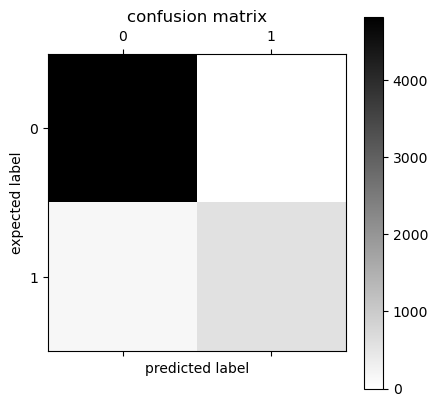

In [62]:
plt.matshow(confusion_matrix(messages['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

C:\Users\bromotdi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


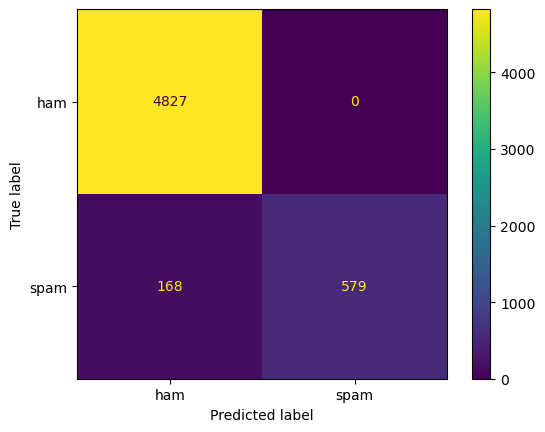

In [63]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(spam_detector, messages_tfidf, messages['label'], normalize=None)

C:\Users\bromotdi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


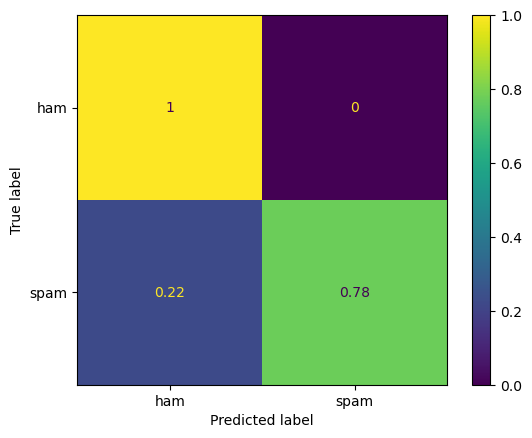

In [64]:
plot_confusion_matrix(spam_detector, messages_tfidf, messages['label'], normalize='true')

From this confusion matrix, we can compute precision and recall, or their combination (harmonic mean) F1:

In [73]:
print(classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      4827
        spam       1.00      0.78      0.87       747

    accuracy                           0.97      5574
   macro avg       0.98      0.89      0.93      5574
weighted avg       0.97      0.97      0.97      5574



There are quite a few possible metrics for evaluating model performance. Which one is the most suitable depends on the task. For example, the cost of mispredicting "spam" as "ham" is probably much lower than mispredicting "ham" as "spam".

## Step 5: How to run experiments?

In the above "evaluation", we committed a cardinal sin. For simplicity of demonstration, we evaluated accuracy on the same data we used for training. **Never evaluate on the same dataset you train on! Bad! Incest!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way -- thanks to this process, we make sure we are not "cheating", and that our final evaluation on test data is representative of true predictive performance.

In [74]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

print( len(msg_train), len(msg_test), len(msg_train) + len(msg_test) )

4459 1115 5574


So, as requested, the test size is 20% of the entire dataset (1115 messages out of total 5574), and the training is the rest (4459 out of 5574).

Let's recap the entire pipeline up to this point, putting the steps explicitly into scikit-learn's `Pipeline`:

In [75]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

A common practice is to partition the training set again, into smaller subsets; for example, 5 equally sized subsets. Then we train the model on four parts, and compute accuracy on the last part (called "validation set"). Repeated five times (taking different part for evaluation each time), we get a sense of model "stability". If the model gives wildly different scores for different subsets, it's a sign something is wrong (bad data, or bad model variance). Go back, analyze errors, re-check input data for garbage, re-check data cleaning.

In our case, everything goes smoothly though:

In [76]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print( scores )

[0.95067265 0.95515695 0.96412556 0.94618834 0.93273543 0.94170404
 0.94618834 0.96412556 0.9529148  0.95730337]


The scores are indeed a little bit worse than when we trained on the entire dataset (5574 training examples, accuracy 0.97). They are fairly stable though:

In [77]:
print( scores.mean(), scores.std() )

0.9511115029979343 0.009335611524248943


In [78]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Wall time: 41.9 s


<module 'matplotlib.pyplot' from 'C:\\Users\\bromotdi\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

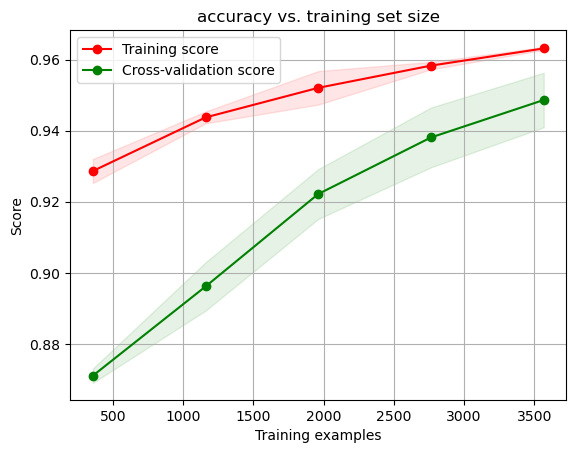

In [79]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", msg_train, label_train, cv=5)

(We're effectively training on 64% of all available data: we reserved 20% for the test set above, and the 5-fold cross validation reserves another 20% for validation sets => `0.8*0.8*5574=3567` training examples left.)

## Step 6: How to tune parameters?

What we've seen so far is only a tip of the iceberg: there are many other parameters to tune. One example is what algorithm to use for training.

We've used Naive Bayes above, but scikit-learn supports many classifiers out of the box: Support Vector Machines, Nearest Neighbours, Decision Trees, Ensamble methods...

[![](http://radimrehurek.com/data_science_python/drop_shadows_background.png)](http://peekaboo-vision.blogspot.cz/2013/01/machine-learning-cheat-sheet-for-scikit.html)

We can ask: What is the effect of IDF weighting on accuracy? Does the extra processing cost of lemmatization (vs. just plain words) really help?

Let's find out:

In [83]:
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas, split_into_tokens),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(n_splits=5),  # what type of cross validation to use
)

In [84]:
%time nb_detector = grid.fit(msg_train, label_train)

Wall time: 21.5 s


In [85]:
nb_detector.cv_results_

{'mean_fit_time': array([3.55324144, 3.47778287, 2.58615751, 2.63511376]),
 'std_fit_time': array([0.0177804 , 0.16194276, 0.0077055 , 0.06725176]),
 'mean_score_time': array([0.96937132, 0.85044422, 0.63608122, 0.58832154]),
 'std_score_time': array([0.04433853, 0.02630721, 0.00446817, 0.06903731]),
 'param_bow__analyzer': masked_array(data=[<function split_into_lemmas at 0x00000211D0616550>,
                    <function split_into_lemmas at 0x00000211D0616550>,
                    <function split_into_tokens at 0x00000211CB0ED3A0>,
                    <function split_into_tokens at 0x00000211CB0ED3A0>],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_tfidf__use_idf': masked_array(data=[True, False, True, False],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'bow__analyzer': <function __main__.split_into_lemmas(message)>,
   'tfidf__use_idf': True},
  {'bow

(best parameter combinations are displayed first: in this case, `use_idf=True` and `analyzer=split_into_lemmas` take the prize).

A quick sanity check:

In [86]:
print( nb_detector.predict_proba(["Hi mom, how are you?"])[0] )
print( nb_detector.predict_proba(["WINNER! Credit for free!"])[0] )

[0.99325369 0.00674631]
[0.30938045 0.69061955]


The `predict_proba` returns the predicted probability for each class (ham, spam). In the first case, the message is predicted to be ham with > 99% probability, and spam with < 1%. So if forced to choose, the model will say "ham":

In [87]:
print( nb_detector.predict(["Hi mom, how are you?"])[0] )
print( nb_detector.predict(["WINNER! Credit for free!"])[0] )

ham
spam


And overall scores on the test set, the one we haven't used at all during training:

In [88]:
predictions = nb_detector.predict(msg_test)
print( confusion_matrix(label_test, predictions) )
print( classification_report(label_test, predictions) )

[[959   0]
 [ 52 104]]
              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       959
        spam       1.00      0.67      0.80       156

    accuracy                           0.95      1115
   macro avg       0.97      0.83      0.89      1115
weighted avg       0.96      0.95      0.95      1115



This is then the realistic predictive performance we can expect from our spam detection pipeline, when using lowercase with lemmatization, TF-IDF and Naive Bayes for classifier.

Let's try with another classifier: [Support Vector Machines (SVM)](http://en.wikipedia.org/wiki/Support_vector_machine). SVMs are a great starting point when classifying text data, getting state of the art results very quickly and with pleasantly little tuning (although a bit more than Naive Bayes):

In [89]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),  # <== change here
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(n_splits=5),  # what type of cross validation to use
)

In [91]:
%time svm_detector = grid_svm.fit(msg_train, label_train) # find the best combination from param_svm
print( svm_detector.cv_results_ )

Wall time: 1min 33s
{'mean_fit_time': array([3.93921571, 4.19208555, 4.29802313, 4.21886034, 4.42013764,
       5.10390954, 5.5099781 , 5.37229733, 5.99276071, 5.08409367,
       4.66310086, 4.94625239]), 'std_fit_time': array([0.03171421, 0.11412494, 0.10345096, 0.02903408, 0.04138566,
       0.76613145, 0.63656793, 0.24896209, 0.34679272, 0.34418836,
       0.13960111, 0.02776998]), 'mean_score_time': array([0.99801993, 1.13042998, 1.0130456 , 1.00948491, 1.1831233 ,
       1.39270482, 1.35038157, 1.23234577, 1.44773507, 1.19226809,
       1.20426745, 1.14649043]), 'std_score_time': array([0.10656971, 0.05910774, 0.03226384, 0.00993813, 0.15940871,
       0.12531144, 0.12983271, 0.1420623 , 0.1573428 , 0.04287788,
       0.00508296, 0.05261897]), 'param_classifier__C': masked_array(data=[1, 10, 100, 1000, 1, 1, 10, 10, 100, 100, 1000, 1000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?'

So apparently, linear kernel with `C=1` is the best parameter combination.

Sanity check again:

In [92]:
print( svm_detector.predict(["Hi mom, how are you?"])[0] )
print( svm_detector.predict(["WINNER! Credit for free!"])[0] )

ham
spam


In [93]:
print( confusion_matrix(label_test, svm_detector.predict(msg_test)) )
print( classification_report(label_test, svm_detector.predict(msg_test)) )

[[958   1]
 [ 10 146]]
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       959
        spam       0.99      0.94      0.96       156

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



This is then the realistic predictive performance we can expect from our spam detection pipeline, when using SVMs.

## Step 7: Productionalizing a predictor

With basic analysis and tuning done, the real work (engineering) begins.

The final step for a production predictor would be training it on the entire dataset again, to make full use of all the data available. We'd use the best parameters found via cross validation above, of course. This is very similar to what we did in the beginning, but this time having insight into its behaviour and stability. Evaluation was done honestly, on distinct train/test subset splits.

The final predictor can be serialized to disk, so that the next time we want to use it, we can skip all training and use the trained model directly:

In [98]:
import pickle

with open('sms_spam_detector.pkl', 'wb') as fout:
    pickle.dump(svm_detector, fout)

# ...and load it back, whenever needed, possibly on a different machine
with open('sms_spam_detector.pkl', 'rb') as fin:
    svm_detector_reloaded = pickle.load(fin)

The loaded result is an object that behaves identically to the original:

In [99]:
print( 'before:', svm_detector.predict([message4])[0] )
print( 'after:', svm_detector_reloaded.predict([message4])[0] )

before: ham
after: ham


Another important part of a production implementation is **performance**. After a rapid, iterative model tuning and parameter search as shown here, a well performing model can be translated into a different language and optimized. Would trading a few accuracy points give us a smaller, faster model? Is it worth optimizing memory usage, perhaps using `mmap` to share memory across processes?

Note that optimization is not always necessary; always start with actual profiling.

Other things to consider here, for a production pipeline, are **robustness** (service failover, redundancy, load balancing), **monitoring** (incl. auto-alerts on anomalies) and **HR fungibility** (avoiding "knowledge silos" of how things are done, arcane/lock-in technologies, black art of tuning results). These days, even the open source world can offer viable solutions in all of these areas. All the tool shown today are free for commercial use, under OSI-approved open source licenses.